## Understanding Generalization in Quantum Machine Learning with Margins

This is an introductory tutorial for the paper [Understanding Generalization in Quantum Machine Learning with Margins[1]](https://openreview.net/pdf?id=iQQ2zuWhFM). The full code can be found in [this Github repository](https://github.com/takh04/Q-margin).

Due to the work done by [Caro et al.[2]](https://arxiv.org/abs/2111.05292), generalization in Quantum Machine Learning has been widely understood with the number of trainable parameters. However, [Gil-Fuster et al.[3]](https://arxiv.org/abs/2306.13461) pointed out that this generalization bound is an *uniform bound* and QML models can overfit the randomized labels. In such cases, it is well known that the generalization bounds become vacuous [4](https://arxiv.org/abs/1611.03530).

In our paper, we introduce margin-based generalization bounds for QML models, inspired by [Bartlett et al.[5]](https://arxiv.org/pdf/1706.08498). 
#### Theorem 
*Consider an $n$-qubit QNNs consist of unitary $U \in \mathbb{U}_Q$ and POVMs $\{E_i\}_{i=1}^k$ for $k$-class classification. Let $b$ be a distance bound such that $\|U - U_\mathrm{ref}\|_{2,1} \leq b$ holds for any $U \in \mathbb{U}_Q$, with $U_\mathrm{ref}$ serving as the reference unitary matrix. Then, for any $\delta > 0$ and $\gamma > 0$, with probability at least $1 - \delta$ over the random draw of an i.i.d. sample $S$ of size $m$, the following inequality holds for all $h \in \mathcal{H}$:*
$$
        R(h) \leq \hat{R}_\gamma(h) + \tilde{O}\left(\frac{b}{\gamma} \sqrt{\frac{n}{m}\sum_{i=1}^k\|E_i\|^2_\sigma} + \sqrt{\frac{\ln(1/\delta)}{m}}\right). 
$$

In this introductory tutorial, we will reproduce the randomized label experiments done by [Gil-Fuster et al.[3]](https://arxiv.org/abs/2306.13461), which showed that number of parameters is a vacouous measure of the generalization. However, we will look at the margin distribution and demonstrate that margin, unlike the number of parameters, can capture the generalization behaviour of QML models under randomized labels.

This tutorial was tested under following environments:
```
python=3.10
pennylane==0.40.0
torch==2.7.1
tensorflow==2.19.0
scikit-learn==1.7.0
matplotlib==3.10.3
```

### 0. Data Generation

We will train various QML models for Quantum Phase Recognition (QPR) problem. First, we will generate the ground states of generalized cluster Hamiltonian. Note, this is a four class classification tasks, with equal probability among each classes.

In [1]:
import pennylane as qml
import numpy as np
import os
import torch

np.random.seed(42)
torch.manual_seed(42)
# Generalized Cluster Hamiltonian
def H(j1, j2, N):
    coeffs, ops = [], []
    for n in range(N):
        ops.append(qml.PauliZ(n))
        coeffs.append(1)
    for n in range(N - 1):
        ops.append(qml.PauliX(n) @ qml.PauliX(n+1))
        coeffs.append(-j1)
    for n in range(N - 2):
        ops.append(qml.PauliX(n) @ qml.PauliZ(n+1) @qml.PauliX(n+2))
        coeffs.append(-j2)
    H = qml.Hamiltonian(coeffs, ops)
    return qml.matrix(H)

def gs(j1, j2, N):
    eigvals, eigvecs = np.linalg.eigh(H(j1, j2, N))
    return eigvecs[:,0]

def labels(j1, j2):
    if (j2 <= j1 - 1) and (j2 <= -j1 -1):
        y = 0
        pass_rate = 4 / 29
    elif (j2 > -j1 - 1) and (j2 <= j1 - 1):
        y = 1
        pass_rate = 4 / 15.5
    elif (j2 > j1 - 1) and (j2 <= -j1 -1):
        y = 2
        pass_rate = 4 / 15.5
    elif (j2 > j1 - 1) and (j2 > -j1 -1):
        if j2 >= 1:
            y = 0
            pass_rate = 4 / 29
        else:
            y = 3
            pass_rate = 1
    return y, pass_rate

        

def gen_data(num_qubits, num_samples, test):
    j1j2_list = []
    gs_list = []
    y_list = []

    if test:
        directory = f'data/test/'
    else:
        directory = f'data/train/'
        
    if not os.path.exists(directory):
        os.makedirs(directory)

    sample_count = 0
    while sample_count < num_samples:
        j1, j2 = 8 * (np.random.random() - 0.5), 8 * (np.random.random() - 0.5)
        y, pass_rate = labels(j1, j2)
        
        rand = np.random.random()
        if rand < pass_rate:
            ground_state = gs(j1, j2, num_qubits)
            j1j2_list.append([j1, j2])
            gs_list.append(ground_state)
            y_list.append(y)
            sample_count += 1
    
    with open(os.path.join(directory, 'gs_j1j2.txt'), 'w') as f:
        f.write(str(j1j2_list))
    
    gs_list = np.array(gs_list)
    np.save(os.path.join(directory, 'gs.npy'), gs_list)

    y_list = np.array(y_list)
    np.save(os.path.join(directory, 'label_r=0.0.npy'), y_list)
    
    for noise_level in [0.5, 1.0]:
        label_file = os.path.join(directory, f'label_r={noise_level}.npy')
        if not os.path.exists(label_file):
            noisy_labels = y_list.copy()
            random_indices = np.random.choice(num_samples, int(noise_level * num_samples), replace=False)
            noisy_labels[random_indices] = np.random.randint(0, 4, size=len(random_indices))
            np.save(label_file, noisy_labels)
        

Generate 20 training samples of four-qubit ground states for generalized cluster hamiltonians.

In [2]:
num_qubits = 4
num_samples = 20
gen_data(num_qubits, num_samples, False)

Generate 1000 test samples to evaluate the generalization performances.

In [3]:
num_samples = 1000
gen_data(num_qubits, num_samples, True)

### 1. Define the Model

Now we will define four-qubit Quantum Convolutional Neural Networks.

In [4]:
def construct_model(n_qubits, n_layers):
    # SU4 Ansatz
    def U_SU4(params, wires): # 15 params
        qml.U3(params[0], params[1], params[2], wires=wires[0])
        qml.U3(params[3], params[4], params[5], wires=wires[1])
        qml.CNOT(wires=[wires[0], wires[1]])
        qml.RY(params[6], wires=wires[0])
        qml.RZ(params[7], wires=wires[1])
        qml.CNOT(wires=[wires[1], wires[0]])
        qml.RY(params[8], wires=wires[0])
        qml.CNOT(wires=[wires[0], wires[1]])
        qml.U3(params[9], params[10], params[11], wires=wires[0])
        qml.U3(params[12], params[13], params[14], wires=wires[1])
    
    # QCNN structure
    def QCNN4_shared(params, num_layers):
    # 15 * (num_layers + 1) params
        for i in range(num_layers):
            U_SU4(params[15 * i : 15 * (i + 1)], wires=[0,1])
            U_SU4(params[15 * i : 15 * (i + 1)], wires=[2,3])
    
            U_SU4(params[15 * i : 15 * (i + 1)], wires=[3,0])
            U_SU4(params[15 * i : 15 * (i + 1)], wires=[1,2])
        
        U_SU4(params[15 * num_layers : 15 * (num_layers + 1)], wires=[2,0])
        
    dev = qml.device("default.qubit", wires=n_qubits)
    @qml.qnode(dev)
    def circuit(inputs, params):
        qml.AmplitudeEmbedding(inputs, wires=range(n_qubits))
        QCNN4_shared(params, n_layers)
        return qml.probs(wires=[0,2])
    
    weight_shapes = {"params": (15 * (n_layers + 1))}

    class model(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes=weight_shapes)
        def forward(self, x):
            return self.qlayer(x)
    model = model()
    return model

### 2. Train and Evaluate the Model

We train the model for 1000 iterations with learning rate 0.05 using Cross Entropy Loss. After the training we compute the margin distribution and save the margin boxplots, containing the minimum, lower quantile, median, upper quantile, and maximum values of the margin distribution. Then, test accuracy is computed.

In [5]:
# Model Training Utility
def train_and_eval(model, X, y, X_test, y_test):
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.05)
    X_batch = torch.tensor(X, dtype=torch.float32)
    y_batch = torch.tensor(y, dtype=torch.long)
    
    for step in range(1000):
        pred = model(X_batch)
        loss = loss_fn(pred, y_batch)
        opt.zero_grad()
        loss.backward()
        opt.step()

    model.eval()
    # Compute Margin Distribution
    margin_dists = []
    y_tensor = torch.from_numpy(y).to(torch.long)
    probs = model(torch.from_numpy(X).to(torch.float32))
    preds = torch.argmax(probs, dim=1)
    correct_label_probs = probs.gather(1, y_tensor.to(torch.long).view(-1, 1)).squeeze(1)
    incorrect_label_probs, _ = torch.max(probs.masked_fill(torch.eye(probs.size(1))[y_tensor].bool(), float('-inf')), dim=1)
    margin_dist = correct_label_probs - incorrect_label_probs
    margin_mean = margin_dist.mean().item()
    # Zero out margins for incorrect predictions
    margin_dist = torch.where(preds == y_tensor, margin_dist, torch.zeros_like(margin_dist))
    margin_dists.append(margin_dist)

    # Concatenate all margins
    margin_dist = torch.cat(margin_dists, dim=0)

    # Calculate margin statistics
    margin_min = margin_dist.min().item()
    margin_Q1 = torch.quantile(margin_dist, 0.25).item()
    margin_Q2 = torch.quantile(margin_dist, 0.50).item()
    margin_Q3 = torch.quantile(margin_dist, 0.75).item()
    margin_max = margin_dist.max().item()
    margin_boxplot = np.array([margin_min, margin_Q1, margin_Q2, margin_Q3, margin_max])

    # Compute Test Accuracy
    correct_predictions = 0
    probs_test = model(torch.from_numpy(X_test).to(torch.float32))
    preds_test = torch.argmax(probs_test, dim=1)
    correct_predictions += (preds_test == y_test).sum().item()
    accuracy = correct_predictions / len(y_test)
    return margin_boxplot, accuracy

We train three QCNNs with one, three, and five layers. We train three models for pure label ($r=0.0$), half-randomized label ($r=0.5$), and fully-randomized label ($r=1.0$).

In [6]:
# Experiment parametersr 
model_layers_list = [1, 3, 5]
r_list = [0.0, 0.5, 1.0]

# 1. Initialize a dictionary to store all your results
results = {r: {'margins': [], 'accuracies': []} for r in r_list}

# 2. Loop by 'r' first, then by model, to group data logically for plotting
print("--- Starting Training and Data Collection ---")
for r in r_list:
    print(f"Processing noise level r = {r}")
    
    # Load data that depends on 'r' once per outer loop
    y = np.load(f'data/train/label_r={r}.npy')
    y_test = np.load(f'data/test/label_r={r}.npy')
    
    for num_layers in model_layers_list:
        # Construct the model
        model = construct_model(4, num_layers)

        # Load data (using dummy data for this example)
        X = np.load('data/train/gs.npy')
        X_test = np.load('data/test/gs.npy')

        # Train and get results
        margin_boxplot, accuracy = train_and_eval(model, X, y, X_test, y_test)
        
        # 3. Save the results in the dictionary
        results[r]['margins'].append(margin_boxplot)
        results[r]['accuracies'].append(accuracy)

print("\n--- Data Collection Complete ---")

--- Starting Training and Data Collection ---
Processing noise level r = 0.0


/var/folders/s2/t3n82l2s329dh9dttmtv7vr00000gn/T/ipykernel_20963/2306987488.py:6: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:307.)
  X_batch = torch.tensor(X, dtype=torch.float32)


Processing noise level r = 0.5
Processing noise level r = 1.0

--- Data Collection Complete ---


### 4. Visualize the Results

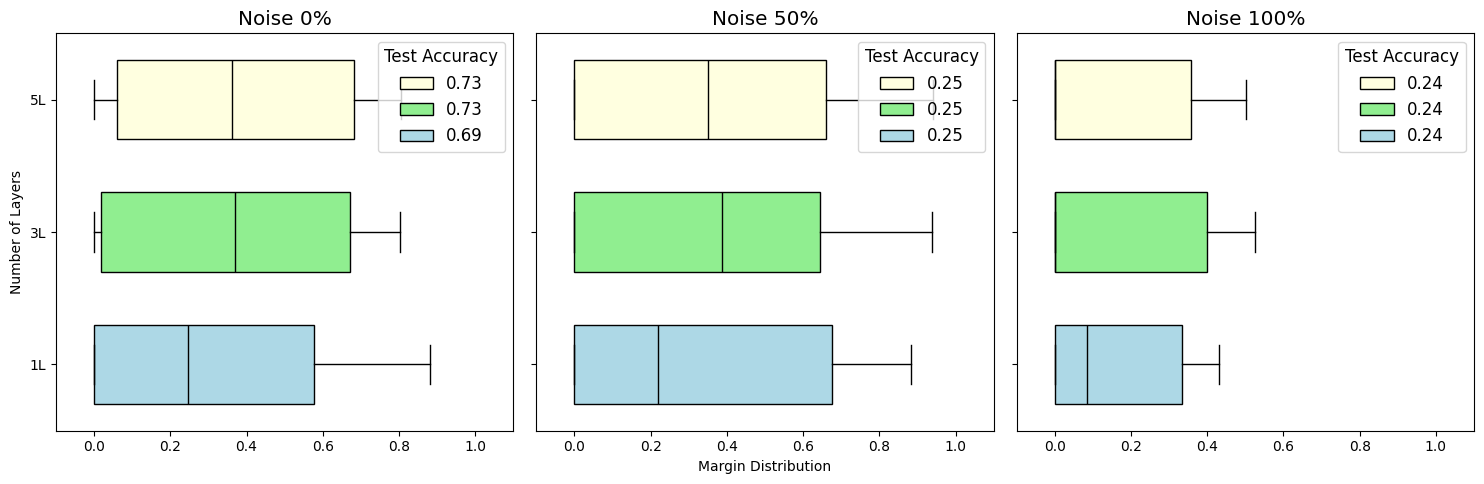

In [7]:
import matplotlib.pyplot as plt

def plot_results(results_dict):
    """Generates a box plot from the stored results dictionary."""
    
    model_layers_list = [1, 3, 5] # Must match the order used during training
    r_list = list(results_dict.keys())

    # Create figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    plt.rcParams.update({'font.size': 12})
    
    # Define plot styles
    colors = ["lightyellow", "lightgreen", "lightblue"] # Colors for 1, 3, 5 layers
    positions = [2, 1, 0] # Positions for 5, 3, 1 layers (top to bottom)

    # Loop through each noise level to create a subplot
    for ax, r in zip(axes, r_list):
        # 1. Retrieve the pre-calculated data for this 'r'
        margin_data = results_dict[r]['margins']
        accuracy_data = results_dict[r]['accuracies']

        # 2. Reverse data to plot layers [5, 3, 1] at positions [2, 1, 0]
        reversed_margins = margin_data[::-1]
        reversed_accuracies = accuracy_data[::-1]
        reversed_layers = model_layers_list[::-1]
        
        box_patches = []
        for i in range(len(reversed_margins)):
            bp = ax.boxplot(
                reversed_margins[i],
                positions=[positions[i]],
                widths=0.6,
                vert=False,
                patch_artist=True,
                showfliers=False,
                boxprops=dict(facecolor=colors[i]),
                medianprops=dict(color='black')
            )
            box_patches.append(bp["boxes"][0])
        
        # 3. Configure the subplot
        ax.set_xlim(-0.1, 1.1)
        ax.set_yticks(positions, [f"{l}L" for l in reversed_layers])
        ax.set_title(f"Noise {int(r*100)}%")
        
        # 4. Create legend from accuracy data
        legend_labels = [f'{acc:.2f}' for acc in reversed_accuracies]
        ax.legend(box_patches, legend_labels, loc='upper right', title="Test Accuracy")

    # Final figure adjustments
    axes[0].set_ylabel("Number of Layers")
    axes[1].set_xlabel("Margin Distribution")

    plt.tight_layout()
    plt.savefig("final_margin_boxplot.pdf")
    plt.show()

# --- Call the plotting function with your collected data ---
plot_results(results)

As expected, the test accuracies decrease as the label noise increases. Concurrently, we also see that margin distribution shifting to the left. This leftward shift leads to larger upper bound in margin-based generalization bounds. Hence, our margin generalization bounds correctly captures the generalization behaviours under label corruption for QML models!

In our [full paper[1]](https://arxiv.org/abs/2411.06919), we investigate larger qubit systems with additional datasets. We also directly compare number of parameters and margins as a measure of generalization performance using mutual information and Kendall's rank correlation. Finally, we connect a concept of margin with quantum state discrimination problems, and suggest a quantum embedding methods for better generalization performance. 

### References

1. Tak Hur, Daniel K. Park. *Understanding Generalization in Quantum Machine Learning with Margins*. ICML (2025).

2. Matthias C. Caro, Hsin-Yuan Huang. *Generalization in quantum machine learning from few training data*. Nature Communications (2022).

3. Elies Gil-Fuster, Jens Eisert, Carlos Bravo-Prieto. *Understanding quantum machine learning also requires rethinking generalization*. Nature Communications (2024).

4. Peter Bartlett, Dylan J. Foster, Matus Telgarsky. *Spectrally-normalized margin bounds for neural networks* Neurips (2017).

### Citation

If you use this code in your research, please cite our paper:
```
@article{hur2024understanding,
  title={Understanding Generalization in Quantum Machine Learning with Margins},
  author={Hur, Tak and Park, Daniel K},
  journal={arXiv preprint arXiv:2411.06919},
  year={2024}
}
```